In [594]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import mixture

from utilities import load_images_from_folder, crop_image, intensity_clipping, get_coordinates, get_training_data

In [595]:
images = load_images_from_folder("processed data")

Processing images: 100%|███████████████████████| 13/13 [00:00<00:00, 202.24it/s]


In [596]:
expdata = images[4]
training_data, training_coordinates = get_training_data(expdata,32)
training_coordinates[:,[1,0]] = training_coordinates[:,[0,1]]
d0, d1, d2 = training_data.shape

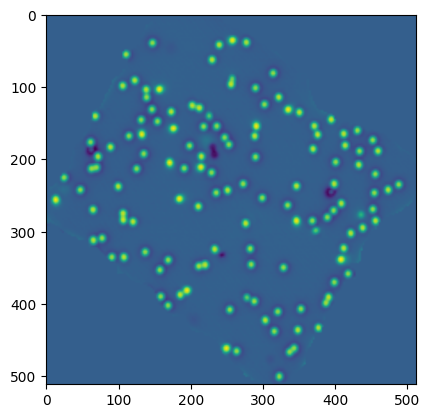

In [597]:
plt.imshow(expdata)

In [598]:
class_1_counts = []
class_2_counts = []

for i in range(0,15,1):
    window_size = 32
    n_components = 2
    covariance = 'diag'
    random_state = i
    clf = mixture.GaussianMixture(
        n_components = n_components,
        covariance_type = covariance,
        random_state = random_state)
    X_vec = training_data.reshape(d0,d1*d2)
    classes = clf.fit_predict(X_vec) +1
    cla = np.ndarray(shape=(
        np.amax(classes), int(window_size), int(window_size)))

    cl_all = []
    for i in range(np.amax(classes)):
        cl = training_data[classes == i + 1]
        cl_all.append(cl)
        cla[i] = np.mean(cl, axis=0)

    class_1_counts.append(len(cl_all[0]))
    class_2_counts.append(len(cl_all[1]))

class_1_counts = np.array(class_1_counts)
class_2_counts = np.array(class_2_counts)
possible_distributions = np.concatenate((class_1_counts,class_2_counts))

In [599]:
most_frequent_distribution = np.bincount(possible_distributions).argmax()
random_state_choice = np.where(class_1_counts == most_frequent_distribution)[0][0]


GMM components


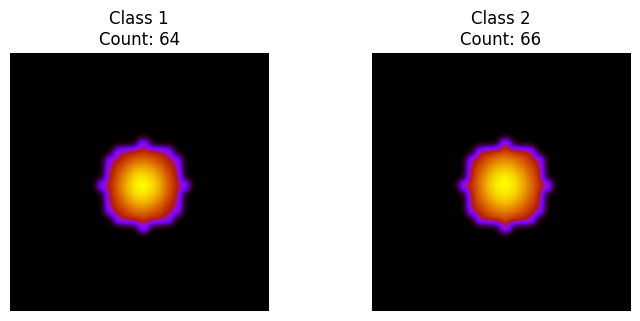

In [600]:
window_size = 32
n_components = 2
covariance = 'diag'
random_state = random_state_choice
clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec = training_data.reshape(d0,d1*d2)
classes = clf.fit_predict(X_vec) +1
cla = np.ndarray(shape=(
    np.amax(classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)
print('\nGMM components')

cl_all = []
for i in range(np.amax(classes)):
    cl = training_data[classes == i + 1]
    cl_all.append(cl)
    cla[i] = np.mean(cl, axis=0)
    ax = fig.add_subplot(gs[i])
    ax.imshow(cla[i, :, :], cmap='gnuplot',
            interpolation='Gaussian')
    ax.axis('off')
    ax.set_title('Class '+str(i+1)+'\nCount: '+str(len(cl)))

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

In [601]:
probs = clf.predict_proba(X_vec)

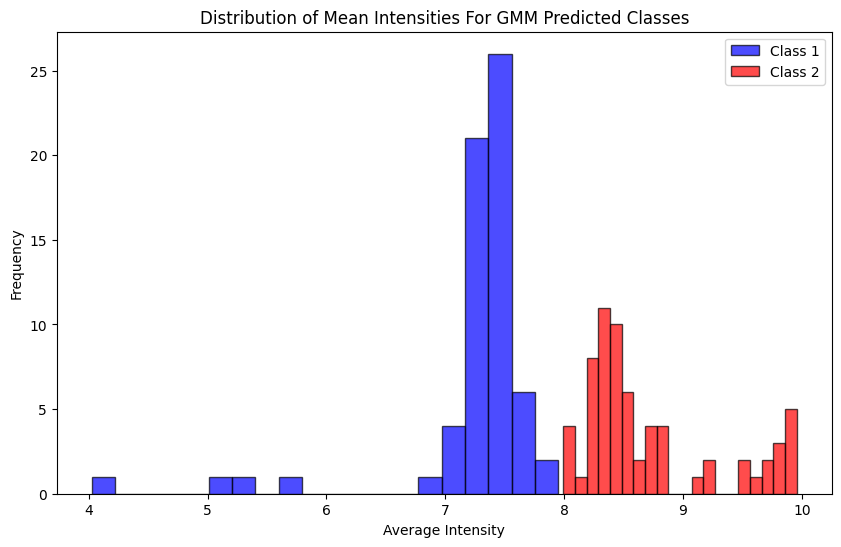

In [602]:
class_labels = np.unique(classes)

class_1_indices = np.where(classes == class_labels[0])
class_1_average_intensities = []

class_2_indices = np.where(classes == class_labels[1])
class_2_average_intensities = []

for i in class_1_indices[0]:
    class_1_average_intensity = np.mean(training_data[i])
    class_1_average_intensities.append(class_1_average_intensity)
    
for i in class_2_indices[0]:
    class_2_average_intensity = np.mean(training_data[i])
    class_2_average_intensities.append(class_2_average_intensity)

class_1_average_intensities = np.array(class_1_average_intensities)
class_2_average_intensities = np.array(class_2_average_intensities)

plt.figure(figsize=(10, 6))
plt.hist(class_1_average_intensities, bins=20, alpha=0.7, label='Class 1', color='blue', edgecolor='black')
plt.hist(class_2_average_intensities, bins=20, alpha=0.7, label='Class 2', color='red', edgecolor='black')
plt.title('Distribution of Mean Intensities For GMM Predicted Classes')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

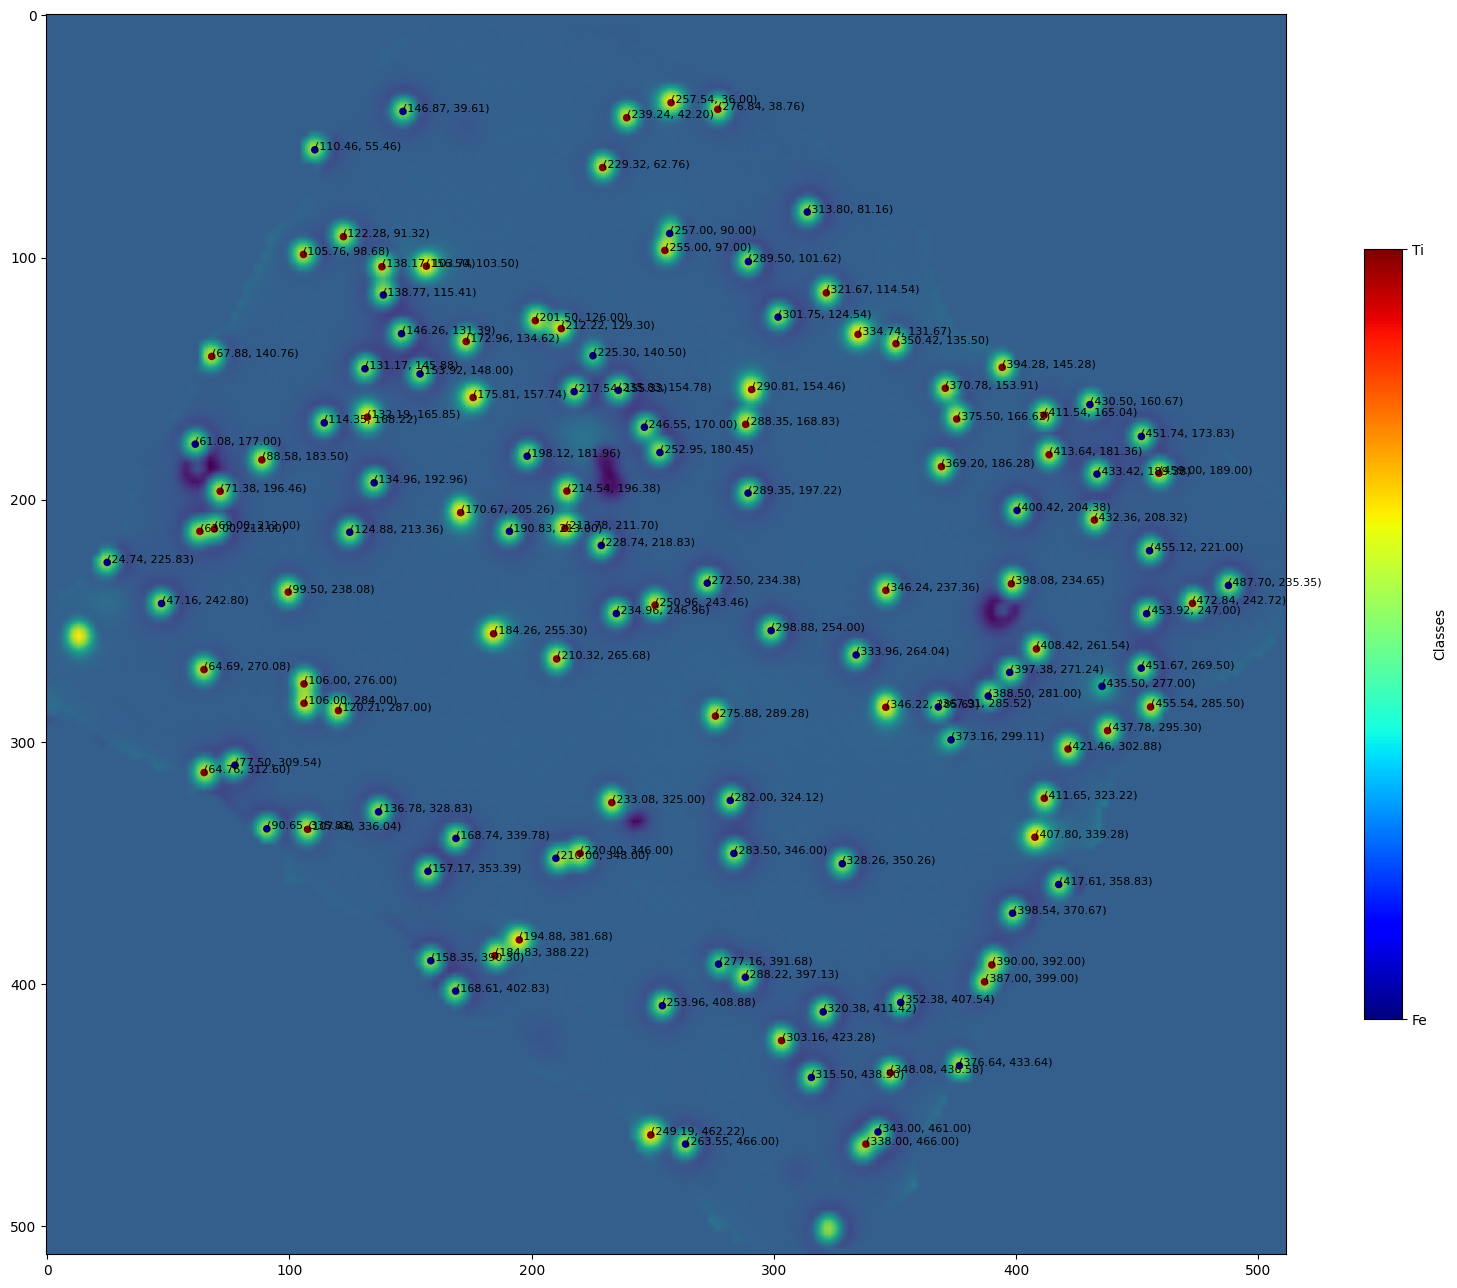

In [603]:
classes = classes.astype(object)
if np.min(class_1_average_intensities) < np.min(class_2_average_intensities):
    classes[classes == 1] = "Fe"
    classes[classes == 2] = "Ti"

else:
    classes[classes == 2] = "Fe"
    classes[classes == 1] = "Ti"

class_labels, class_numeric = np.unique(classes, return_inverse=True)

plt.figure(figsize=(20, 20))
sc = plt.scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=class_numeric, s=20,
            cmap="jet")
im = plt.imshow(expdata)
cbar = plt.colorbar(sc, shrink=0.5, label="Classes")
cbar.set_ticks(np.arange(len(class_labels)))
cbar.set_ticklabels(class_labels)
for i, coord in enumerate(training_coordinates):
    plt.text(coord[0], coord[1], f'({coord[0]:.2f}, {coord[1]:.2f})', fontsize=8, color='black')
plt.show()